<a href="https://colab.research.google.com/github/Thuyhuong123/DA01-day15/blob/main/B%E1%BA%A3n_sao_c%E1%BB%A7a_Ryo_Round_3_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [17]:
# Đọc dữ liệu từ om_cleaned.csv
df = pd.read_csv('/content/drive/MyDrive/Ryo Round 3/om_cleaned.csv')

# Đảm bảo cột 'creation_datetime' ở định dạng datetime
df['creation_datetime'] = pd.to_datetime(df['creation_datetime'])

# Đọc dữ liệu calendar chứa các ngày lễ
calendar = pd.read_csv('/content/drive/MyDrive/Ryo Round 3/ryo_calendar.csv')
calendar['date'] = pd.to_datetime(calendar['date'])

# Lọc các ngày lễ
holidays = calendar[calendar['comments'].notna()][['date', 'comments']]
holidays.rename(columns={'date': 'ds', 'comments': 'holiday'}, inplace=True)

# Tạo danh sách double days (ngày trùng tháng)
double_days = []
for month in range(1, 13):
    double_days.append(pd.Timestamp(year=2022, month=month, day=month))

# Tạo DataFrame cho double days
double_days_df = pd.DataFrame({
    'holiday': 'Double Day',
    'ds': double_days
})

# Kết hợp các ngày lễ và double days
holidays = pd.concat([holidays, double_days_df], ignore_index=True)

# Tạo biến số lượng đơn hàng theo ngày
daily_orders_df = df.groupby(df['creation_datetime'].dt.date).size().reset_index(name='y')
daily_orders_df.rename(columns={'creation_datetime': 'ds'}, inplace=True)
daily_orders_df['ds'] = pd.to_datetime(daily_orders_df['ds'])

# Thêm biến giả holidays
daily_orders_df['holiday'] = daily_orders_df['ds'].isin(holidays['ds']).astype(int)


<ipython-input-17-eced33616111>:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Ryo Round 3/om_cleaned.csv')


In [19]:
# Chia dữ liệu thành train (quý 1 đến quý 3 năm 2022) và test (quý 4 năm 2022)
train = daily_orders_df[(daily_orders_df['ds'] >= '2022-01-01') & (daily_orders_df['ds'] < '2022-10-01')]
test = daily_orders_df[(daily_orders_df['ds'] >= '2022-10-01') & (daily_orders_df['ds'] < '2023-01-01')]


In [20]:
holidays

,ds,holiday
0,2022-01-01,New Year's Day
1,2022-01-31,Lunar New Year Eve
2,2022-02-01,Lunar New Year
3,2022-02-02,Lunar New Year
4,2022-02-03,Lunar New Year
5,2022-02-04,Lunar New Year
6,2022-02-05,Lunar New Year
7,2022-04-11,Hung King Temple Festival (in lieu)
8,2022-04-30,Reunification Day
9,2022-05-01,Labour Day


In [21]:
# Xác định các tham số SARIMAX
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)  # Theo tuần

# Xây dựng mô hình SARIMAX
model = SARIMAX(train['y'],
                order=order,
                seasonal_order=seasonal_order,
                exog=train[['holiday']],
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit mô hình
results = model.fit(disp=False)
print(results.summary())


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  259
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1880.584
Date:                           Tue, 20 Aug 2024   AIC                           3773.167
Time:                                   11:35:02   BIC                           3794.101
Sample:                                        0   HQIC                          3781.600
                                           - 259                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday     1038.3093     69.202     15.004      0.000     902.676    1173.943
ar.L1          0.3727      0.074      5.011

In [25]:
# Get model residuals
residuals = results.resid

# Calculate Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(train['y'], results.fittedvalues)
print('MAE:', mae)

# Calculate Root Mean Squared Error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train['y'], results.fittedvalues, squared=False)
print('RMSE:', rmse)

# Calculate Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC)
print('AIC:', results.aic)
print('BIC:', results.bic)

MAE: 367.52333315774894
RMSE: 563.5444885534766
AIC: 3773.1674756016596
BIC: 3794.1011019586


In [22]:
# Dự báo cho giai đoạn test
forecast = results.get_forecast(steps=len(test), exog=test[['holiday']])

# Lấy giá trị dự báo và dải tin cậy
forecast_df = forecast.conf_int(alpha=0.05)
forecast_df['yhat'] = forecast.predicted_mean
forecast_df['lower y'] = forecast_df.iloc[:, 0]
forecast_df['upper y'] = forecast_df.iloc[:, 1]
forecast_df = forecast_df[['yhat', 'lower y', 'upper y']].set_index(test.index)


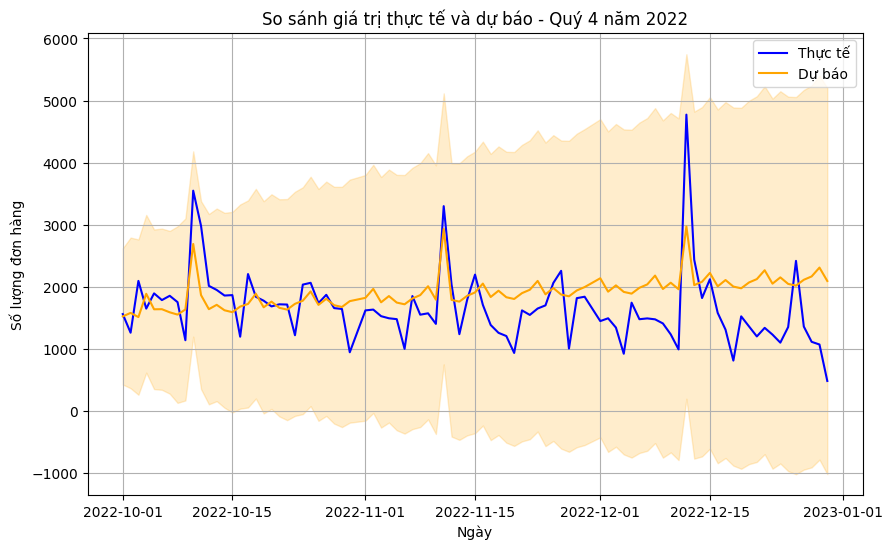

In [23]:
# Vẽ biểu đồ so sánh giữa giá trị thực tế và dự báo
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Thực tế', color='blue')
plt.plot(test['ds'], forecast_df['yhat'], label='Dự báo', color='orange')
plt.fill_between(test['ds'], forecast_df['lower y'], forecast_df['upper y'], color='orange', alpha=0.2)
plt.legend()
plt.title('So sánh giá trị thực tế và dự báo - Quý 4 năm 2022')
plt.xlabel('Ngày')
plt.ylabel('Số lượng đơn hàng')
plt.grid(True)
plt.show()


In [26]:
# Tạo DataFrame cho quý 1 năm 2023, bao gồm cả ngày lễ
future_dates = pd.date_range(start='2023-01-01', end='2023-03-31', freq='D')
future_df = pd.DataFrame({'ds': future_dates})
future_df['holiday'] = 0  # Đặt giá trị mặc định cho 'holiday' là 0
# Nếu có ngày lễ trong quý 1 năm 2023, cập nhật giá trị 'holiday' tương ứng

# Dự báo cho quý 1 năm 2023
forecast = results.get_forecast(steps=len(future_df), exog=future_df[['holiday']])
forecast_df = forecast.conf_int()
forecast_df['yhat'] = forecast.predicted_mean

# Hiển thị kết quả dự báo
print(forecast_df)

         lower y      upper y         yhat
259   430.285847  2621.833117  1526.059482
260   370.088682  2794.872253  1582.480468
261   265.383582  2765.328425  1515.356003
262   620.359695  3160.082970  1890.221332
263   356.178982  2925.373205  1640.776094
..           ...          ...          ...
344  -939.774295  5170.967544  2115.596625
345  -903.762504  5243.340388  2169.788942
346  -779.122509  5403.211528  2312.044509
347 -1012.423124  5204.752780  2096.164828
348  -928.482039  5323.404546  2197.461254

[90 rows x 3 columns]


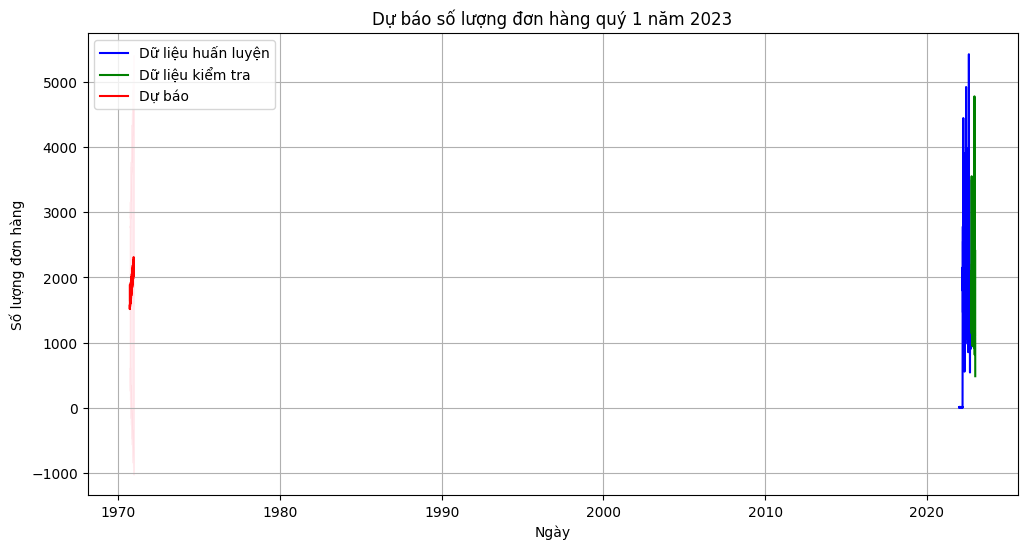

In [27]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ dự báo
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Dữ liệu huấn luyện', color='blue')
plt.plot(test_df['ds'], test_df['y'], label='Dữ liệu kiểm tra', color='green')
plt.plot(forecast_df.index, forecast_df['yhat'], label='Dự báo', color='red')
plt.fill_between(forecast_df.index, forecast_df['lower y'], forecast_df['upper y'], color='pink', alpha=0.3)

plt.legend(loc='best')
plt.title('Dự báo số lượng đơn hàng quý 1 năm 2023')
plt.xlabel('Ngày')
plt.ylabel('Số lượng đơn hàng')
plt.grid(True)
plt.show()

**Chu kỳ 15 ngày**

In [ ]:
# Tách dữ liệu huấn luyện và kiểm tra
train_df = daily_orders_df[daily_orders_df['ds'] <= '2022-10-31']
test_df = daily_orders_df[daily_orders_df['ds'] > '2022-10-31']

# Huấn luyện mô hình SARIMA
# Kiểm tra nếu có thêm biến số lễ hội
model = SARIMAX(train_df['y'],
                exog=train_df[['holiday']],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 15)
                )  # Hàng tuần (15 ngày chu kỳ mùa vụ)
model_fit = model.fit(disp=False)

# Dự báo
forecast = model_fit.get_forecast(steps=len(test_df), exog=test_df[['holiday']])
forecast_df = forecast.conf_int()
forecast_df['yhat'] = forecast.predicted_mean

# So sánh dự báo và giá trị thực tế
forecast_df['y_true'] = test_df['y'].values

# Tính toán MAE và RMSE
mae = mean_absolute_error(forecast_df['y_true'], forecast_df['yhat'])
rmse = np.sqrt(mean_squared_error(forecast_df['y_true'], forecast_df['yhat']))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 354.7690608446166
RMSE: 487.0456298741996


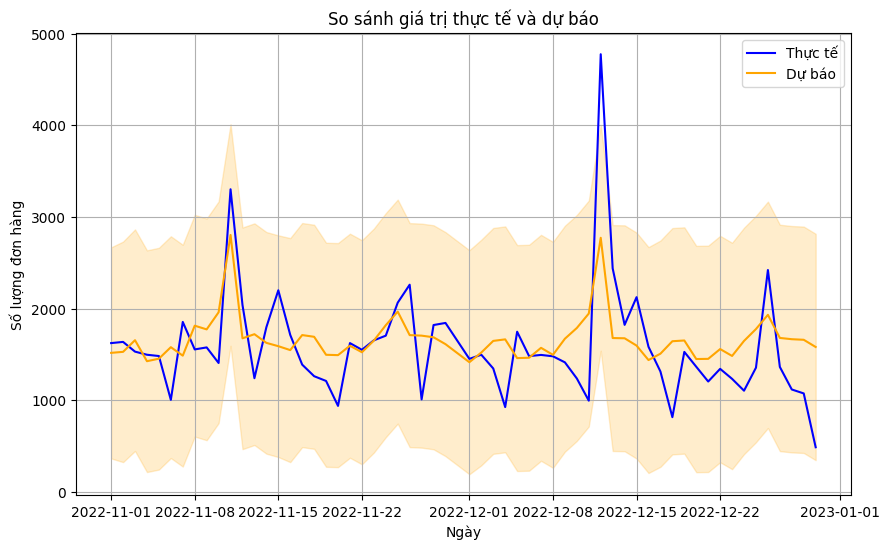

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='Thực tế', color='blue')
plt.plot(test_df['ds'], forecast_df['yhat'], label='Dự báo', color='orange')
plt.fill_between(test_df['ds'], forecast_df['lower y'], forecast_df['upper y'], color='orange', alpha=0.2)
plt.legend()
plt.title('So sánh giá trị thực tế và dự báo')
plt.xlabel('Ngày')
plt.ylabel('Số lượng đơn hàng')
plt.grid(True)
plt.show()


In [ ]:
# Dự báo cho năm 2023 với các biến giả
future_steps = 365  # Dự báo cho 365 ngày trong năm 2023
future_dates = pd.date_range(start='2023-01-01', periods=future_steps, freq='D')

# Tạo DataFrame cho các biến giả trong tương lai
future_df = pd.DataFrame({'ds': future_dates})
future_df['holiday'] = (future_df['ds'].isin(holidays['ds'])).astype(int)
future_df['double_day'] = (future_df['ds'].isin(double_days)).astype(int)

# Dự báo cho tương lai
# Chỉ sử dụng 'holiday' làm biến ngoại sinh, giống như trong quá trình huấn luyện
forecast = model_fit.get_forecast(steps=future_steps, exog=future_df[['holiday']])
forecast_df = forecast.conf_int()
forecast_df['yhat'] = forecast.predicted_mean
forecast_df['ds'] = future_dates # Thêm cột ngày vào DataFrame kết quả

# Hiển thị kết quả dự báo cho năm 2023 bao gồm cả ngày
print(forecast_df[['ds', 'yhat']])
forecast_df.to_csv('du_bao_2023.csv', index=False)
print("Đã lưu kết quả dự báo vào file 'du_bao_2023.csv'")


            ds         yhat
218 2023-01-01  1516.544191
219 2023-01-02  1527.547250
220 2023-01-03  1654.703720
221 2023-01-04  1425.553550
222 2023-01-05  1453.021239
..         ...          ...
578 2023-12-27  1185.126076
579 2023-12-28  1319.171940
580 2023-12-29  1328.949338
581 2023-12-30  1126.273458
582 2023-12-31  1128.611759

[365 rows x 2 columns]
Đã lưu kết quả dự báo vào file 'du_bao_2023.csv'


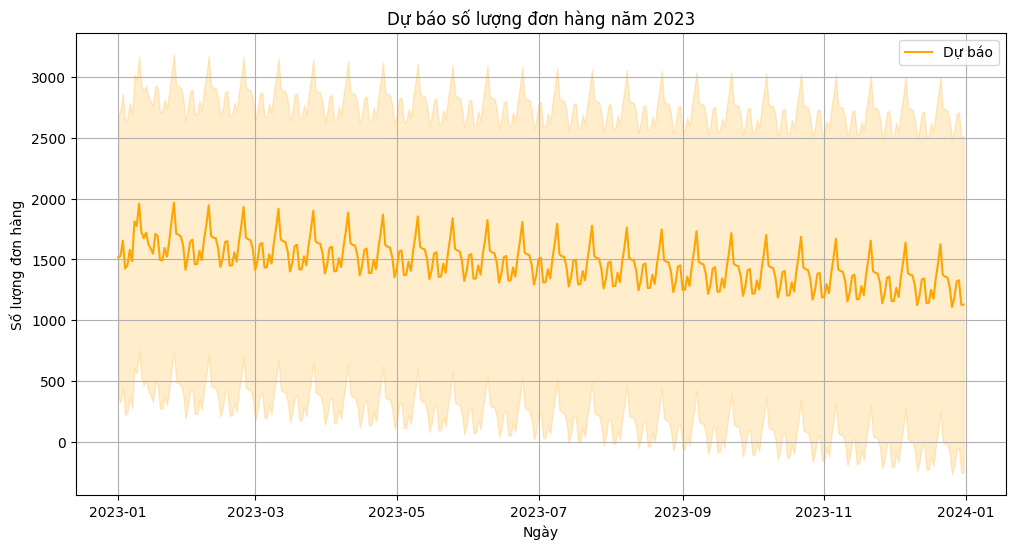

In [ ]:
# Dự báo cho năm 2023 với các biến giả
# ... (code from previous response)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Dự báo', color='orange')
plt.fill_between(forecast_df['ds'], forecast_df['lower y'], forecast_df['upper y'], color='orange', alpha=0.2)
plt.legend()
plt.title('Dự báo số lượng đơn hàng năm 2023')
plt.xlabel('Ngày')
plt.ylabel('Số lượng đơn hàng')
plt.grid(True)
plt.show()

In [ ]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  218
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 15)   Log Likelihood               -1589.369
Date:                            Tue, 20 Aug 2024   AIC                           3190.739
Time:                                    03:39:47   BIC                           3210.588
Sample:                                         0   HQIC                          3198.770
                                            - 218                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday     1076.9642    110.998      9.703      0.000     859.412    1294.517
ar.L1          0.2895      0.072   

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

# Assuming 'test_df' from previous cells contains the actual values and 'forecast_df' the predictions
test_data = test_df['y'].values  # Extract the actual values from your test dataframe

# Trim the forecast to match the length of the test data
forecast_aligned = forecast_df['yhat'].values[:len(test_data)]  # Align predicted values with test_data

r2 = r2_score(test_data, forecast_aligned)
mape = mean_absolute_percentage_error(test_data, forecast_aligned)
rmse = np.sqrt(mean_squared_error(test_data, forecast_aligned))

print(f"R²: {r2}")
print(f"MAPE: {mape}")
print(f"RMSE: {rmse}")

R²: 0.01885196990153759
MAPE: 0.2811332282901434
RMSE: 606.4899587191812
